In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("SemArt/semart_train.csv", sep="	", encoding="unicode_escape")
df.columns = df.columns.str.lower()

In [3]:
len(df["timeframe"].unique())

22

In [4]:
df.columns

Index(['image_file', 'description', 'author', 'title', 'technique', 'date',
       'type', 'school', 'timeframe'],
      dtype='object')

In [5]:
df.groupby("timeframe").size()

timeframe
0751-0800       2
0801-0850       5
0851-0900       3
0951-1000       4
1001-1050       1
1051-1100      26
1101-1150      14
1151-1200      21
1201-1250      29
1251-1300     116
1301-1350     670
1351-1400     347
1401-1450     938
1451-1500    2059
1501-1550    2576
1551-1600    1582
1601-1650    3404
1651-1700    2088
1701-1750    1444
1751-1800    1114
1801-1850    1056
1851-1900    1745
dtype: int64

In [6]:
df.groupby("school").size().sort_values()

school
Finnish             5
Portuguese          5
Polish             16
Norwegian          18
Irish              21
Other              22
Swedish            23
Bohemian           29
Catalan            35
Greek              37
Belgian            45
Scottish           46
Russian            68
Swiss              89
Danish             94
American          113
Hungarian         178
Austrian          216
Netherlandish     217
English           411
Spanish           852
German           1173
Flemish          2016
French           2556
Dutch            2948
Italian          8011
dtype: int64

In [7]:
technique_df = df.groupby("technique").size().to_frame()

CNN

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class CNN(nn.Module):
    def __init__(self, output_dim: int):
        super(CNN, self).__init__()
        self.output_dim = output_dim
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.sequential = nn.Sequential(
            nn.Linear(1000, 64),
            # nn.ReLU(),
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
        )
        self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.sequential(x)
        x = self.softmax(x)
        return x


In [233]:
from enum import Enum
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image


class DataSetEnum(Enum):
    TRAIN = "train"
    TEST = "test"
    VALIDATION = "val"


class OutputEnum(Enum):
    TIMEFRAME = "timeframe"
    SCHOOL = "school"


timeframe_encoder = {
    "0801-0850": 0,
    "0851-0900": 0,
    "0751-0800": 0,
    "0951-1000": 0,
    "1001-1050": 0,
    "1051-1100": 0,
    "1101-1150": 0,
    "1151-1200": 0,
    "1201-1250": 0,
    "1251-1300": 0,
    "1301-1350": 0,
    "1351-1400": 0,
    "1401-1450": 1,
    "1451-1500": 2,
    "1501-1550": 3,
    "1551-1600": 4,
    "1601-1650": 5,
    "1651-1700": 6,
    "1701-1750": 7,
    "1751-1800": 8,
    "1801-1850": 9,
    "1851-1900": 10,
}

school_encoder = {
    "Finnish": 0,
    "Portuguese": 0,
    "Polish": 0,
    "Norwegian": 0,
    "Irish": 0,
    "Other": 0,
    "Swedish": 0,
    "Bohemian": 0,
    "Catalan": 0,
    "Greek": 0,
    "Belgian": 0,
    "Scottish": 0,
    "Russian": 0,
    "Swiss": 0,
    "Danish": 0,
    "American": 0,
    "Hungarian": 0,
    "Austrian": 0,
    "Netherlandish": 0,
    "English": 0,
    "Spanish": 1,
    "German": 2,
    "Flemish": 3,
    "French": 4,
    "Dutch": 5,
    "Italian": 6,
}


class ImageDataset(Dataset):
    def __init__(self, data_set: DataSetEnum, output: OutputEnum):
        self.data_set = data_set
        self.output = output
        self.data = pd.read_csv(
            f"SemArt/semart_{data_set.value}.csv", sep="	", encoding="unicode_escape"
        )
        self.data.columns = self.data.columns.str.lower()
        self._base_path = Path() / "SemArt" / "Images"
        self.transform = transforms.Compose(
            [
                # Get the values from here: https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
                transforms.Resize(232),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self._output_dim = len(set(timeframe_encoder.values()))
        if output == OutputEnum.SCHOOL:
            self._output_dim = len(set(school_encoder.values()))

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        # Set label
        label = -1
        match self.output:
            case OutputEnum.TIMEFRAME:
                label = timeframe_encoder[self.data["timeframe"][idx]]
            case OutputEnum.SCHOOL:
                label = school_encoder[self.data["school"][idx]]

        assert label >= 0, "No label found, invalid output type"

        label_tensor = np.zeros(self._output_dim)
        label_tensor[label] = 1
        label_tensor = torch.tensor(label_tensor, dtype=torch.float32, device=device)

        # load image
        raw_image = Image.open(
            str((self._base_path / str(self.data["image_file"][idx])).resolve())
        ).convert("RGB")
        image: torch.Tensor = self.transform(raw_image)  # type: ignore
        image = image.to(device)
        return image, label_tensor


train_dataset = ImageDataset(DataSetEnum.TRAIN, OutputEnum.TIMEFRAME)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)

In [234]:
model = CNN(len(set(timeframe_encoder.values())))
model.to(device)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
resnet_params = list(map(id, model.resnet.parameters()))
params = filter(lambda p: id(p) not in resnet_params, model.parameters())
optimizer = torch.optim.Adam(params, lr=1e-2)
print(model)

CNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
# TRAIN
size = len(train_dataloader)
model.train()
try:
    for batch, (images, labels) in enumerate(train_dataloader):
        pred = model(images)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # accuracy
        accuracy = (pred.argmax(1) == labels.argmax(1)).sum().item() / len(labels)
        print(f"{batch}/{size} - loss: {loss.item():.4f} - accuracy: {accuracy:.4f}")
        writer.add_scalars("Train/Loss", {"train": loss.item()}, batch)
        if batch % 10 == 0:
            image = images[0]
            rgb_image = image.cpu().permute(1, 2, 0)
            rgb_image = (rgb_image - rgb_image.min()) / (
                rgb_image.max() - rgb_image.min()
            )
            writer.add_image("Image", rgb_image, batch)
except KeyboardInterrupt:
    print("Training interrupted")
    torch.save(model.state_dict(), "model.pth")


0/602 - loss: 1.7327 - accuracy: 0.3438
1/602 - loss: 1.8220 - accuracy: 0.4375
2/602 - loss: 1.8469 - accuracy: 0.2812
3/602 - loss: 1.8715 - accuracy: 0.3750
4/602 - loss: 1.4811 - accuracy: 0.3438
5/602 - loss: 1.7921 - accuracy: 0.3125
6/602 - loss: 2.0371 - accuracy: 0.1875
7/602 - loss: 1.6772 - accuracy: 0.4062
8/602 - loss: 1.4503 - accuracy: 0.4688
Training interrupted


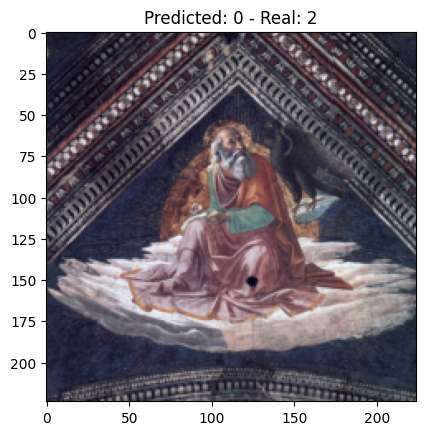

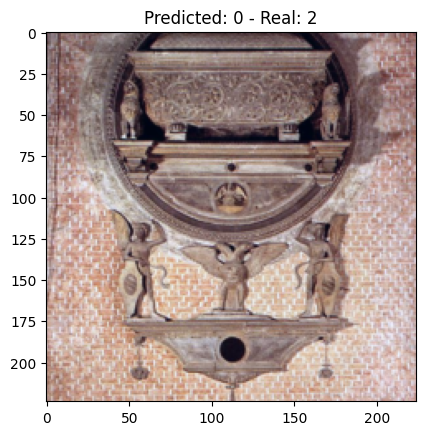

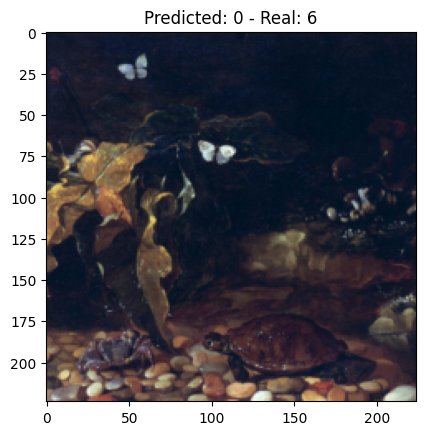

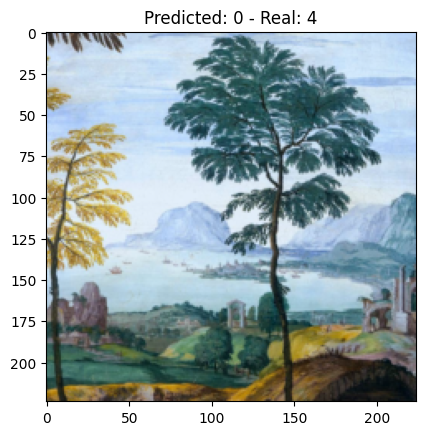

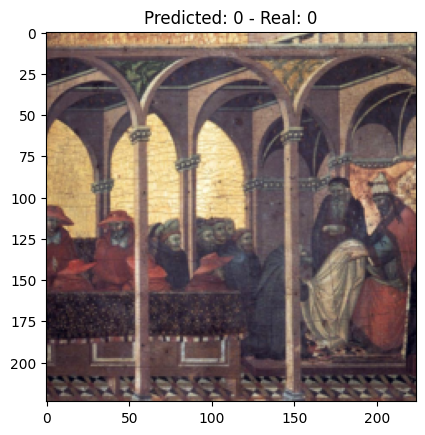

In [241]:
import matplotlib.pyplot as plt

# TEST
model.eval()
test_dataset = ImageDataset(DataSetEnum.TEST, OutputEnum.TIMEFRAME)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)
with torch.no_grad():
    for batch, (images, labels) in enumerate(test_dataloader):
        for image, label in zip(images, labels):
            pred = model(image.unsqueeze(0))
            rgb_image = image.cpu().permute(1, 2, 0)
            rgb_image = (rgb_image - rgb_image.min()) / (
                rgb_image.max() - rgb_image.min()
            )
            plt.imshow(rgb_image)
            plt.title(
                f"Predicted: {pred.argmax().item()} - Real: {label.argmax().item()}"
            )
            plt.show()
        break


In [247]:
data = train_dataset[43]
data[1], model.forward(data[0])

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0'),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
        grad_fn=<LogSoftmaxBackward0>))